In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join
from matplotlib import cm
from scipy import signal
import cmath

In [4]:
def parce_data(filepath: str) -> pd.DataFrame:
    file = open(filepath)
    time_step_index, time_step_time = 0, 0
    ch1_step_index, ch2_step_index = 0, 0
    ch1_step_voltage, ch2_step_voltage = 0, 0
    time, voltage = [], []
    for ind, line in enumerate(file):
        if ind == 2:
            time_step_index, time_step_time = line.split(" = ")
            time_step_index = int(time_step_index)
            time_step_time = float(time_step_time[:-3])
        if ind == 5:
            _, right_part = line.split("  ")
            ch1_step_index, ch1_step_voltage = right_part.split(" = ")
            ch1_step_index = int(ch1_step_index)
            ch1_step_voltage = float(ch1_step_voltage[:-2])
        if ind == 6:
            _, right_part = line.split("  ")
            ch2_step_index, ch2_step_voltage = right_part.split(" = ")
        if ind == 7:
            _, gnd_level_ch1, gnd_level_ch2 = line.split("\t")
            gnd_level_ch1 = int(gnd_level_ch1)
        if ind > 15:
            try:
                N, ch1, ch2 = map(float, line[:-2].split('\t'))
            except:
                N, _, ch1ch2 = line.split(' ')
                N = int(N)
                ch1, ch2 = map(float, ch1ch2.split('\t'))
            voltage.append(ch1 * ch1_step_voltage / ch1_step_index)
            time.append(N * time_step_time / time_step_index)
    voltage = np.array(voltage)
    voltage -= np.mean(voltage)
    res = {"time": time, "voltage": voltage}
    return pd.DataFrame(res)
        

In [5]:
d1 = parce_data("data/3_090A.txt")
d1

,time,voltage
0,0.0096,-0.017719
1,0.0112,-0.003656
2,0.0128,-0.008344
3,0.0144,-0.017719
4,0.0160,-0.027094
...,...,...
4085,6.5456,-0.045844
4086,6.5472,-0.008344
4087,6.5488,0.029156
4088,6.5504,0.052594


Text(0, 0.5, 'Напряжение [В]')

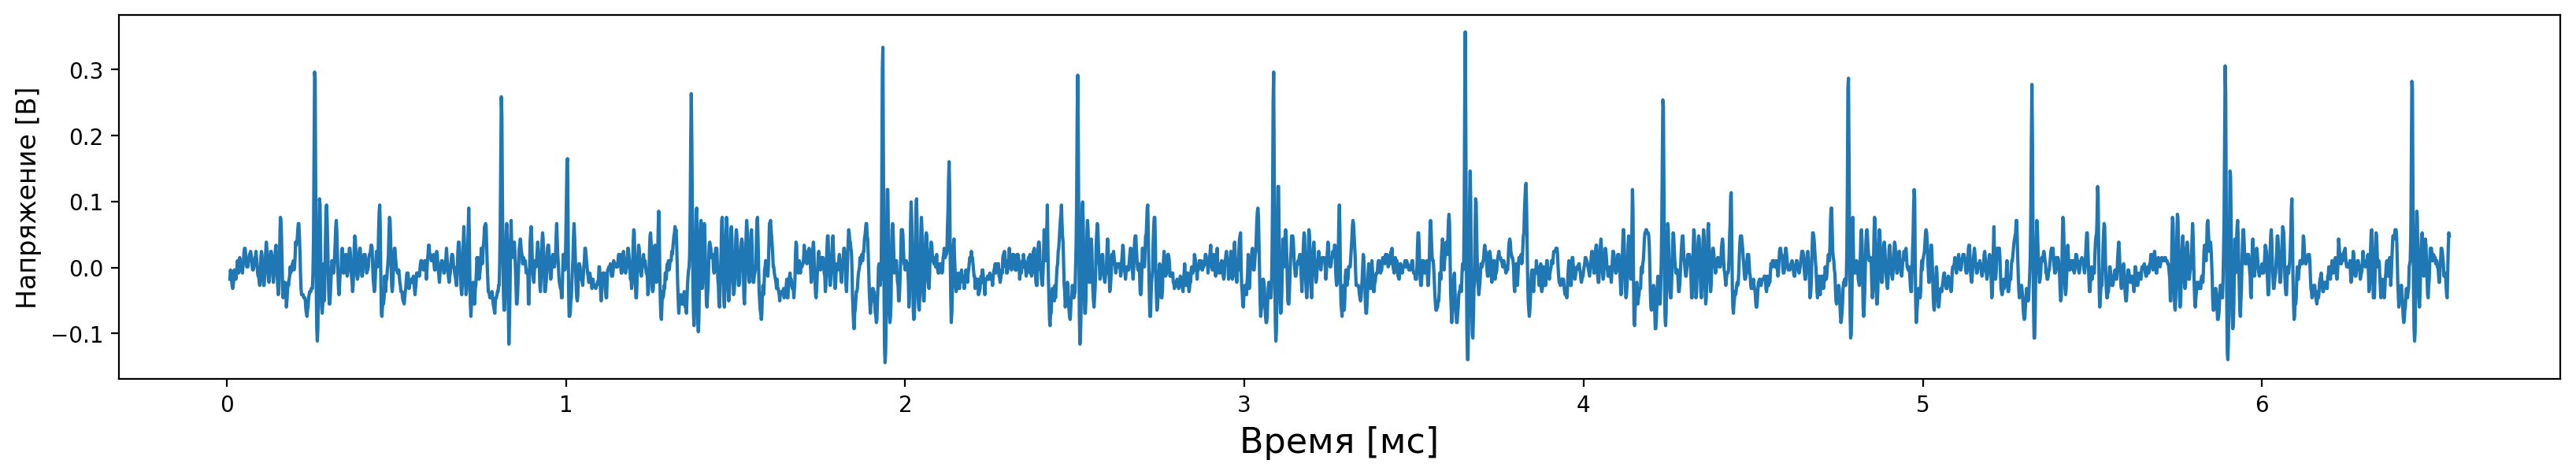

In [6]:
plt.figure(figsize = (20, 3), dpi = 200)
plt.plot(d1.time, d1.voltage)
plt.xlabel("Время [мс]", fontsize = 16)
plt.ylabel("Напряжение [В]", fontsize = 12)

In [7]:
data_path = r'data'
data_file_names = [f for f in listdir(data_path) if isfile(join(data_path, f))]


### Эксперимент 1

In [8]:
experiment_1_file_names = [f for f in data_file_names if len(f) == 10]
current = np.array([float(f[:-5].replace('_', '.')) for f in experiment_1_file_names]) #сила тока накачки в амперах
print(len(experiment_1_file_names))

12


In [25]:
colorpallete = cm.tab20

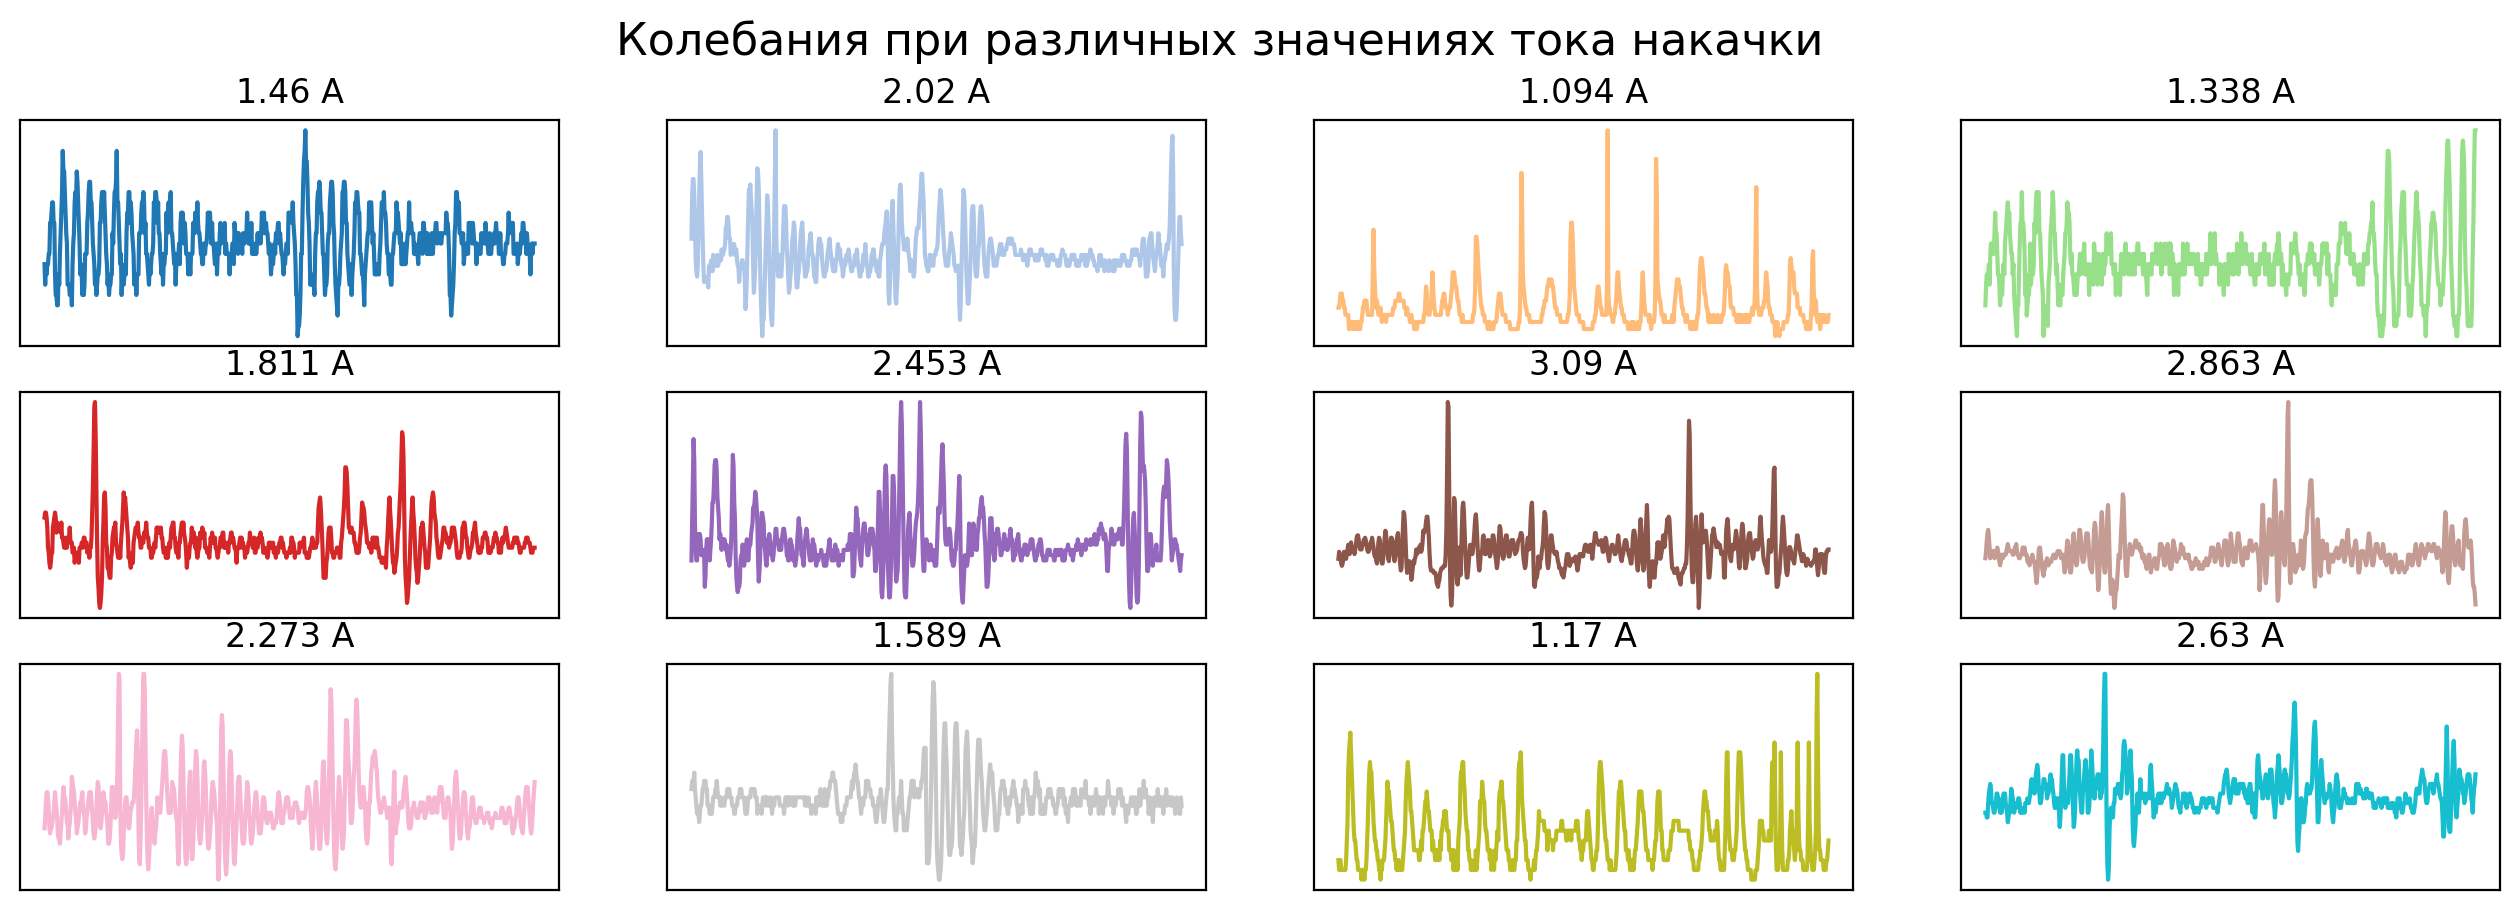

In [26]:
fig, ax = plt.subplots(3, 4, figsize = (16, 5), dpi = 200)
plotable_signal_duration = 700
for ind, (name, I) in enumerate(zip(experiment_1_file_names, current)):
    plotable = ax[ind  // 4][ind % 4]
    data = parce_data(f"{data_path}/{name}")
    plotable.plot(data.time[:plotable_signal_duration], 
                  data.voltage[:plotable_signal_duration],
                  color = colorpallete(ind / 12))
    plotable.set_xticks([])
    plotable.set_yticks([])
    plotable.set_title(f"{I} А")

fig.suptitle("Колебания при различных значениях тока накачки", fontsize = 16);

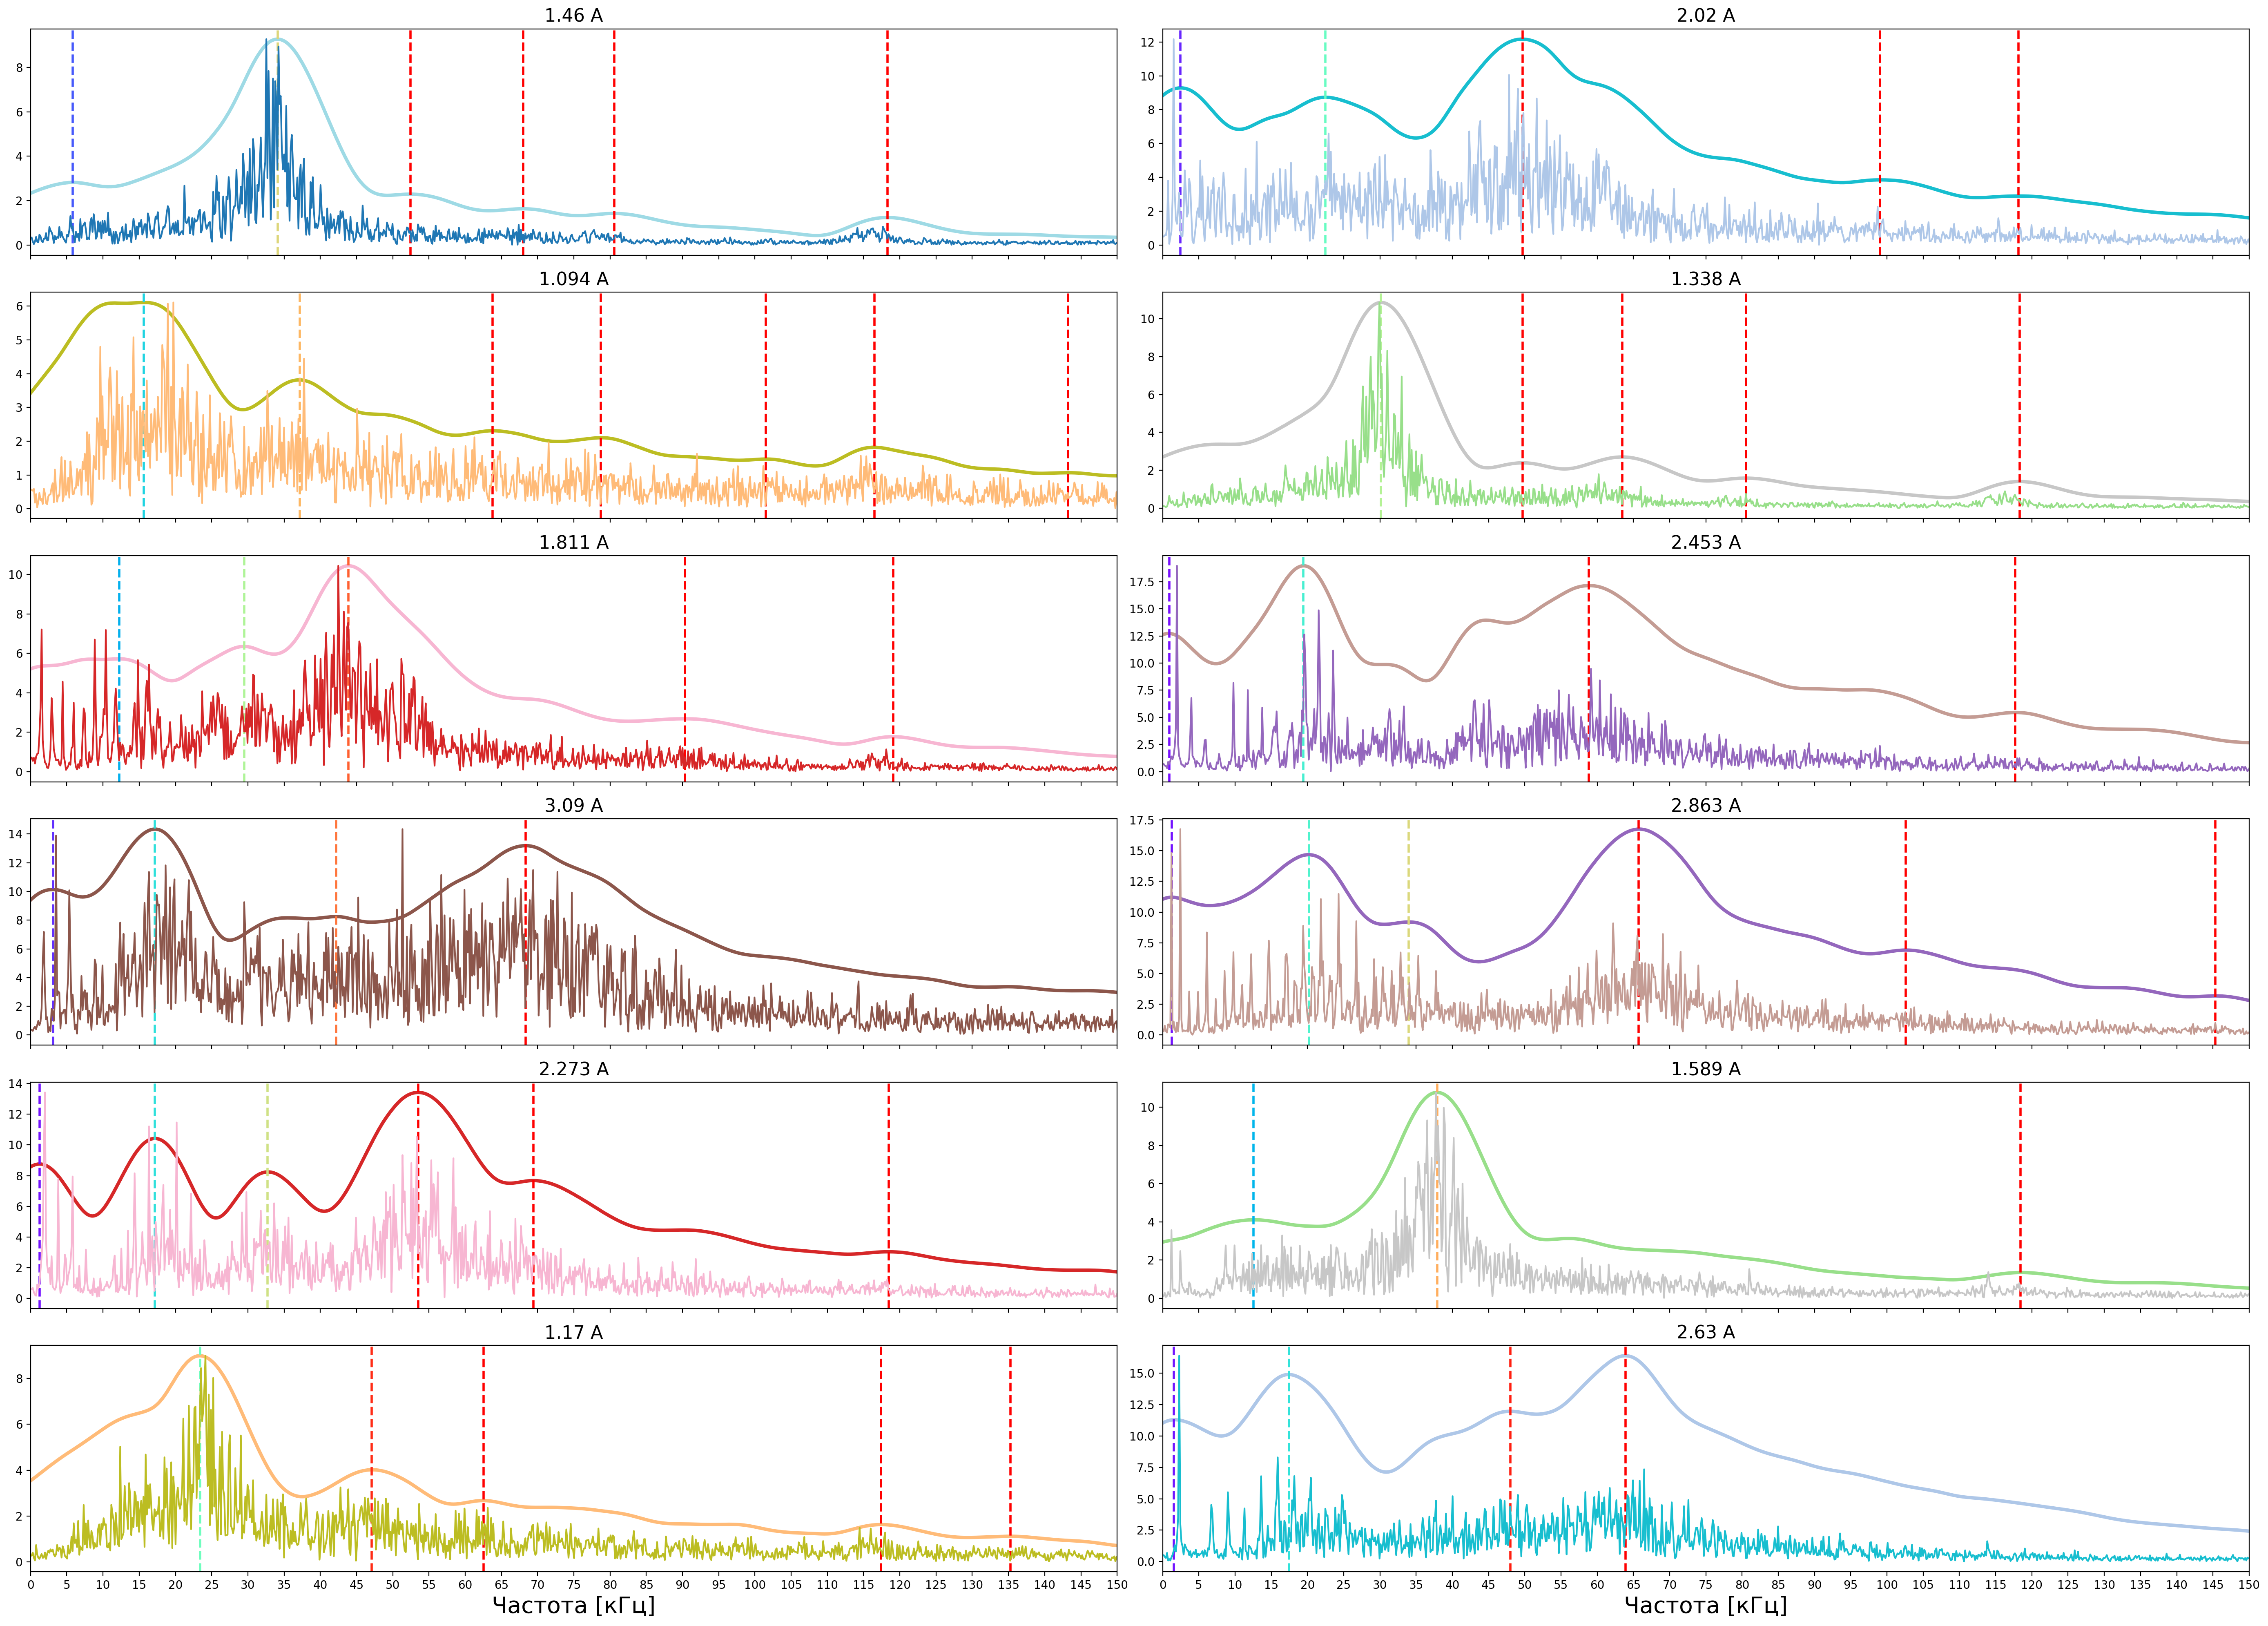

In [90]:
fig, ax = plt.subplots(6, 2, figsize = (28, 20), dpi = 200, sharex = True)
plotable_signal_duration = 700
for ind, (name, I) in enumerate(zip(experiment_1_file_names, current)):
    plotable = ax[ind  // 2][ind % 2]
    data = parce_data(f"{data_path}/{name}")
    
    sample_period = (data.time[1] - data.time[0]) * 1e-3
    freq = np.fft.fftfreq(len(data.voltage), d = sample_period)
    amplitude = np.fft.fft(data.voltage)
    positive_freq_mask = freq > 0
    freq, amplitude = freq[positive_freq_mask] / 1000, np.abs(amplitude[positive_freq_mask])
    
    filter = signal.butter(4, 10, btype = 'low', fs = 1000, output = 'sos')
    filtered_spectrum = signal.sosfilt(filter, amplitude)
    slewed_envlope = np.abs(signal.hilbert(filtered_spectrum)) 
    slewed_envlope = np.max(amplitude) * slewed_envlope / np.max(slewed_envlope)
    maximums, _ = signal.find_peaks(slewed_envlope, width = 20)
    envelope_shift = 7
    plotable.plot(freq - envelope_shift, slewed_envlope, linewidth = 3, color = colorpallete(1 - ind / 12))
    for f in freq[maximums] - envelope_shift:
        plotable.axvline(f, linewidth = 2, color = cm.rainbow(f / 50), linestyle = '--')
    plotable.plot(freq, 
                  amplitude,
                  color = colorpallete(ind / 12))
    plotable.set_xticks(np.arange(0, 160, 5))
    plotable.set_xlim(0, 150)
    plotable.set_title(f"{I} А", fontsize = 16)
    if ind in [10, 11]: plotable.set_xlabel("Частота [кГц]", fontsize = 20)

fig.tight_layout()